# Step 1: Compute eigenfaces

165
(128, 128)


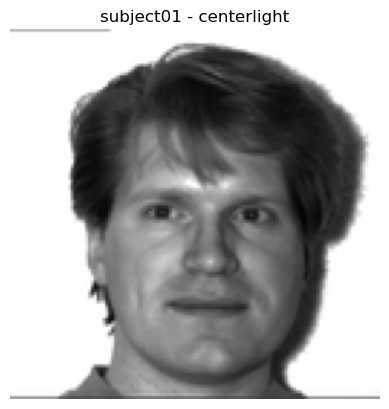

In [1]:
# Load and resize the YaleFaceDatabase images
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt

# Indexing
subjects = ["subject{:02d}".format(i) for i in range(1, 16)]
poses = ["centerlight", "glasses", "happy", "leftlight", "noglasses", "normal", "rightlight", "sad", "sleepy", "surprised", "wink"]

data = dict()

for subject in subjects:
    for pose in poses:
        im = Image.open(f"dataset/YaleFaceDatabase/{subject}.{pose}")
        frames = [frame.copy() for frame in ImageSequence.Iterator(im)]

        # Crop the image (for example, center crop to 200x200)
        width, height = frames[0].size # Original size is 320x243
        new_width, new_height = 243, 243
        offset = -13
        left = width - new_width + offset
        right = left + new_width + offset
        cropped = frames[0].crop((left, 0, right, height))

        # Resize (downsample) to 128x128
        resized = cropped.resize((128, 128), Image.LANCZOS)
        frames[0] = resized
        data[(subject, pose)] = np.array(frames[0])

print(len(data)) # Total number of face images (15 subjects * 11 poses = 165)
print(data[(subjects[0], poses[0])].shape)

# Preview
plt.imshow(data[(subjects[0], poses[0])], cmap='gray')
plt.title(f"{subjects[0]} - {poses[0]}")
plt.axis('off')
plt.show()

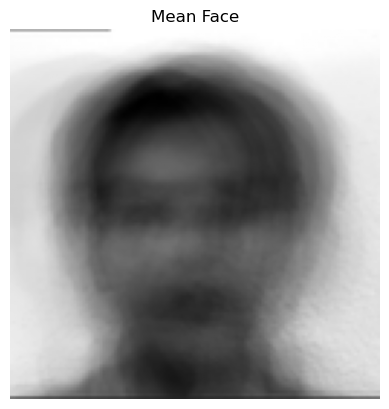

In [2]:
# Eigenface step 1: Compute the mean matrix
sum_matrix = np.zeros((128, 128), dtype=int)
for key, value in data.items():
    sum_matrix += value
mean_matrix = sum_matrix / len(data)

# Preview mean face
plt.imshow(mean_matrix, cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

In [3]:
# Eigenface step 2: center the data
centered_data = dict()
for key, value in data.items():
    centered_data[key] = value - mean_matrix

In [4]:
from sklearn.decomposition import PCA
# Eigenface step 3: PCA on the centered data

## Reshape the data set to a 2D array (n_samples=165, n_features=128*128)
X = np.array([value.flatten() for value in centered_data.values()])

## Apply PCA
pca = PCA()
solver = pca.fit(X)

## Get principal components (eigenfaces)
principal_components = pca.components_  # shape: (n_components (*165=>full), 16384)

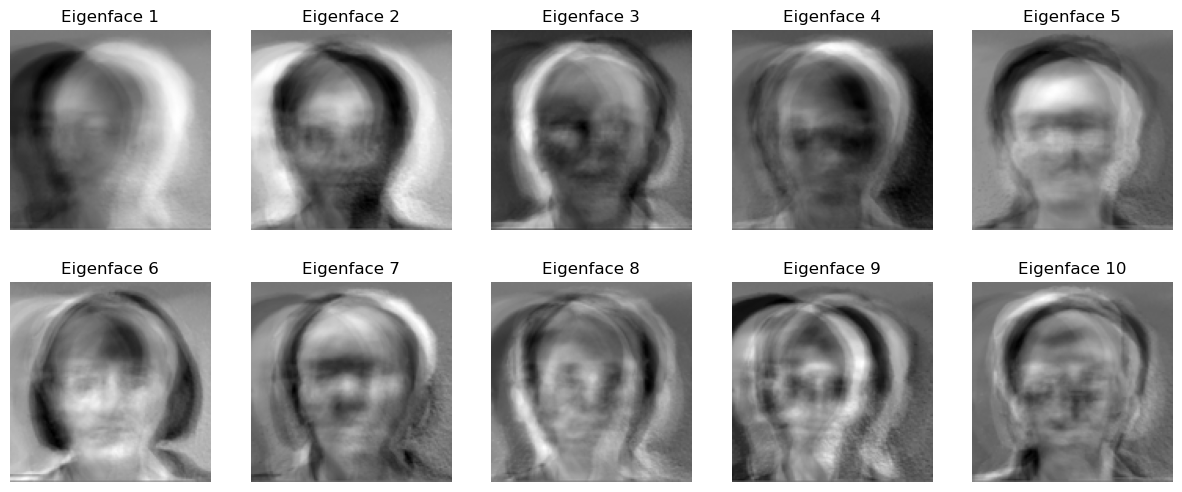

In [5]:
# Visualize the first 10 eigenfaces (principal components)
principal_components_10 = principal_components[:10].reshape((10, 128, 128))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(principal_components_10[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')

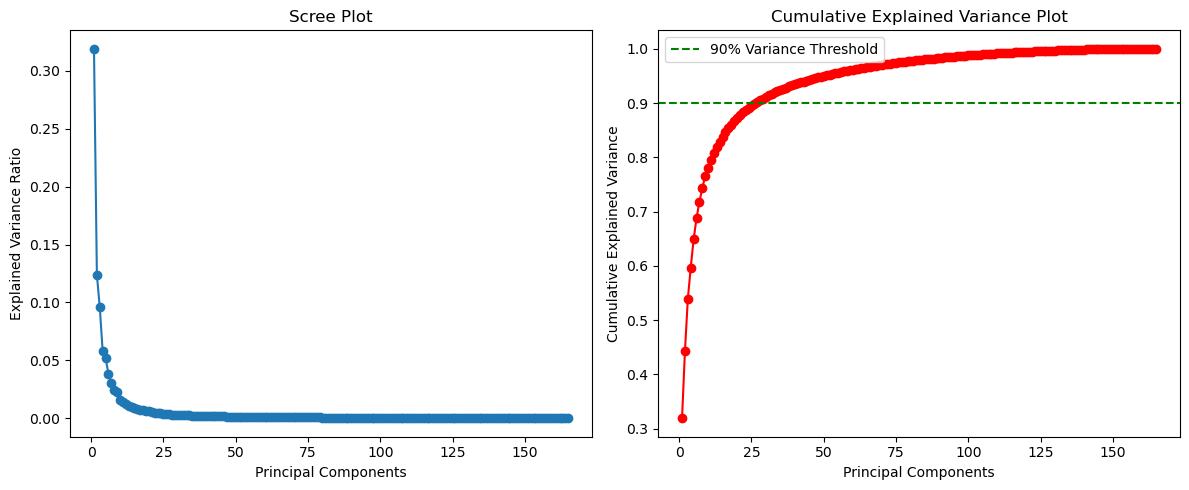

Number of components to retain 90% variance: 26


In [6]:
# Scree plot and cumulative explained variance plot (for determining number of components to keep)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot
axes[0].plot(range(1, explained_variance.shape[0] + 1), explained_variance, marker='o')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')

# Cumulative explained variance plot
axes[1].plot(range(1, cumulative_variance.shape[0] + 1), cumulative_variance, marker='o', color='r')
axes[1].axhline(y=0.9, color='g', linestyle='--', label='90% Variance Threshold')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Determine number of components to retain 90% variance
cumulative_variance_cutoff = cumulative_variance[cumulative_variance <= 0.9]
print(f"Number of components to retain 90% variance: {len(cumulative_variance_cutoff)}")

In this case, we choose $k = 26$ with the 90% threshold on the cumulative explained variance plot!

# Step 2: Projection and Reconstruction

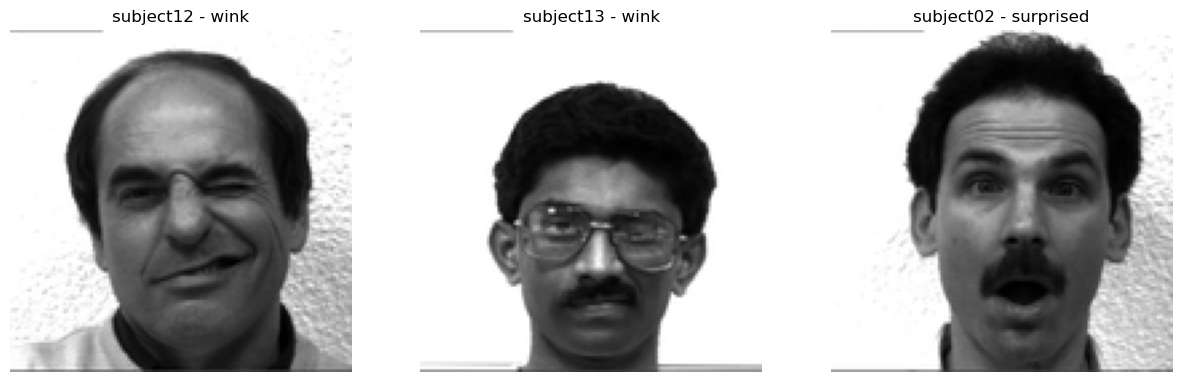

In [7]:
# Randomly draw 3 faces from the dataset!
import random
sample_keys = random.sample(list(data.keys()), 3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, key in enumerate(sample_keys):
    axes[i].imshow(data[key], cmap='gray')
    axes[i].set_title(f"{key[0]} - {key[1]}")
    axes[i].axis('off')

In [8]:
# Project the three faces onto the face space with k = 26 / fixed = 100 / full (165)
k = 26
fixed = 100

## Flatten the selected images
selected_faces = np.array([data[key].flatten() - mean_matrix.flatten() for key in sample_keys])  # shape: (3, 16384)

## Note: Since it is an orthogonal projection, we can directly use the PCA transform method (and chop off the unused components)
selected_faces_full = pca.transform(selected_faces) # shape: (3, 165)
selected_faces_k = selected_faces_full[:, :k]  # shape: (3, k)
selected_faces_fixed = selected_faces_full[:, :fixed]  # shape: (3, 100)

In [9]:
# Compute the squared Euclidean distance between the projections (k = 26)

## Note: Vectorized pairwise distance computation
## selected_faces_k[:, np.newaxis, :]; shape: (3, k) => (3, 1, k)
## selected_faces_k[np.newaxis, :, :]; shape: (3, k) => (1, 3, k)
## subtraction here used the boardcasting feature of numpy, the lower dimension is expanded to match the higher dimension
## this essentially computes the pairwise distance between all the points in selected_faces_k
## shape now is (3, 3, k), square then summing along the last axis gives a (3, 3) distance matrix!
distances_k = np.sum((selected_faces_k[:, np.newaxis, :] - selected_faces_k[np.newaxis, :, :]) ** 2, axis=-1)
print("Squared Eucledian distances between the 3 selected faces (k=26):")
print(distances_k)

# Then, reconstruct the faces from the projections (k = 26)
reconstructed_faces_k = selected_faces_k @ principal_components[:k, :]  # shape: (3, 16384)
## Reshape the reconstructed faces back to 128x128
reconstructed_faces_k_sqr = reconstructed_faces_k.reshape((3, 128, 128)) + mean_matrix  # add the mean back

Squared Eucledian distances between the 3 selected faces (k=26):
[[0.00000000e+00 1.07635412e+08 6.12205444e+07]
 [1.07635412e+08 0.00000000e+00 1.15577609e+08]
 [6.12205444e+07 1.15577609e+08 0.00000000e+00]]


In [10]:
# Project and reconstruction with fixed = 100 and full = 165
reconstructed_faces_fixed = selected_faces_fixed @ principal_components[:fixed, :]  # shape: (3, 16384)
reconstructed_faces_fixed_sqr = reconstructed_faces_fixed.reshape((3, 128, 128)) + mean_matrix  # add the mean back
reconstructed_faces_full = selected_faces_full @ principal_components  # shape: (3, 16384)
reconstructed_faces_full_sqr = reconstructed_faces_full.reshape((3, 128, 128)) + mean_matrix  # add the mean back

# The squared Euclidean distance between the k = 26 and fixed = 100 reconstructed faces
distances_k_fixed = np.sum((reconstructed_faces_k[:, np.newaxis, :] - reconstructed_faces_fixed[np.newaxis, :, :]) ** 2, axis=-1)
print("Squared Euclidean distances between the k = 26 and fixed = 100 reconstructed faces:")
print(distances_k_fixed)

Squared Euclidean distances between the k = 26 and fixed = 100 reconstructed faces:
[[4.81481462e+06 1.12822968e+08 7.44349073e+07]
 [1.12450226e+08 5.18755652e+06 1.28791972e+08]
 [6.60353590e+07 1.20765165e+08 1.32143629e+07]]


The two distance matrics from the two cells above matches (up to a small error). That is because the faces have smaller and smaller variance on the pricinpal components added - making the pairwise distance stable.

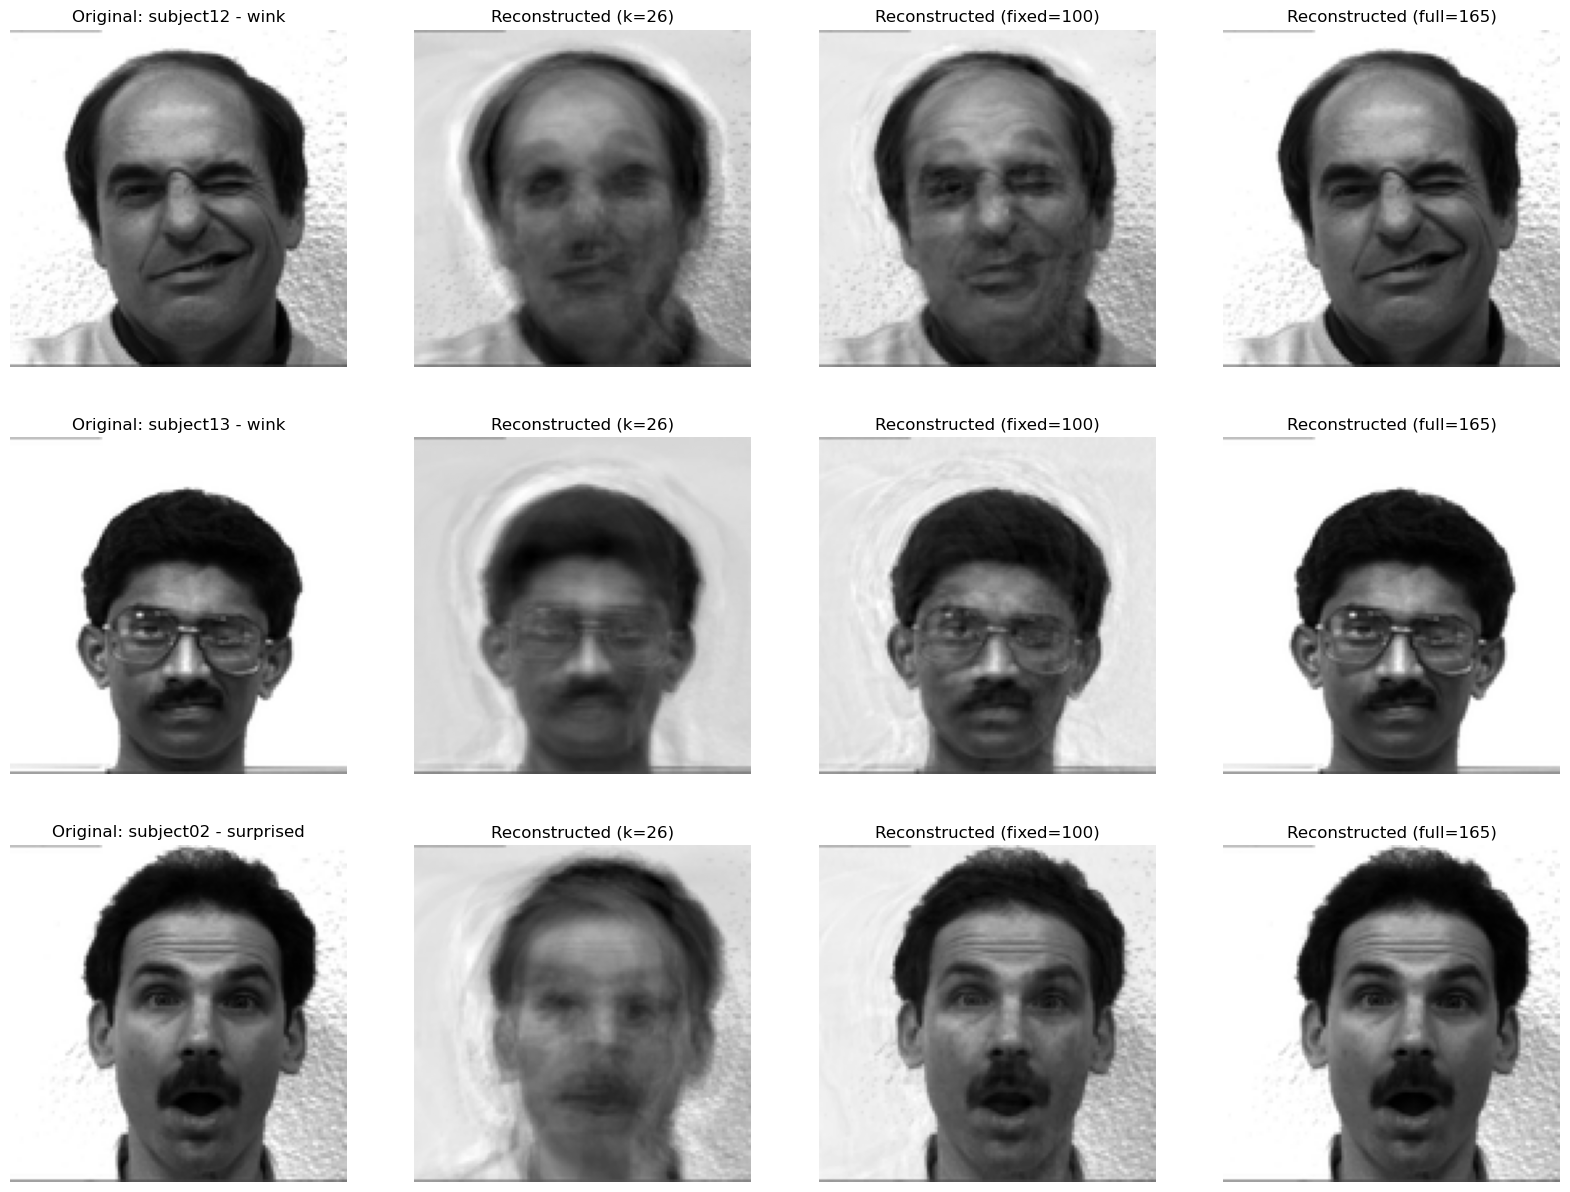

In [11]:
# Visualize the original and reconstructed faces
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i in range(3):
    # Original face
    axes[i, 0].imshow(data[sample_keys[i]], cmap='gray')
    axes[i, 0].set_title(f"Original: {sample_keys[i][0]} - {sample_keys[i][1]}")
    axes[i, 0].axis('off')

    # Reconstructed face (k = 26)
    axes[i, 1].imshow(reconstructed_faces_k_sqr[i], cmap='gray')
    axes[i, 1].set_title(f"Reconstructed (k=26)")
    axes[i, 1].axis('off')

    # Reconstructed face (fixed = 100)
    axes[i, 2].imshow(reconstructed_faces_fixed_sqr[i], cmap='gray')
    axes[i, 2].set_title(f"Reconstructed (fixed=100)")
    axes[i, 2].axis('off')

    # Reconstructed face (full = 165)
    axes[i, 3].imshow(reconstructed_faces_full_sqr[i], cmap='gray')
    axes[i, 3].set_title(f"Reconstructed (full=165)")
    axes[i, 3].axis('off')


# Step 3: Classification Using Eigenfaces

In [12]:
# Dataset construction
## Step 1: Train-test split
from sklearn.model_selection import train_test_split
keys = list(data.keys())
test_size = 0.2
train_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=42)
train_data = {key: data[key] for key in train_keys}
test_data = {key: data[key] for key in test_keys}
print(f"Train set size: {len(train_data)}, Test set size: {len(test_data)}")

Train set size: 132, Test set size: 33


In [13]:
import pandas as pd

# Train and evaluate functions
def train(k=10, trainset=train_data):
    mean_face = None
    projected_trainset = None

    # Eigenface step 1: Compute the mean matrix
    sum_matrix = np.zeros((128, 128), dtype=int)
    for key, value in trainset.items():
        sum_matrix += value
    mean_face = sum_matrix / len(trainset)

    # Eigenface step 2: Center the data
    centered_data = dict()
    for key, value in trainset.items():
        centered_data[key] = value - mean_matrix

    # Eigenface step 3: Apply the PCA
    X = np.array([value.flatten() for value in centered_data.values()])
    pca = PCA()
    solver = pca.fit(X)

    # Eigenface step 4: Project the data onto the top-k principal components
    # Store projections in a pandas DataFrame for efficient computation and metadata handling
    projections = pca.transform(X)[:, :k]
    # Ensure the keys and projections have the same length
    projected_trainset = pd.DataFrame({
        'key': list(centered_data.keys()),
        'projection': list(projections)
    })
    projected_trainset.set_index('key', inplace=True)

    return mean_face, pca, projected_trainset

def test(mean_face, pca, projected_trainset, k=10, testset=test_data):
    # Step 1: Center the test data
    centered_test_data = dict()
    for key, value in testset.items():
        centered_test_data[key] = value - mean_face

    # Step 2: Project the centered test data onto the PCA space
    X_test = np.array([value.flatten() for value in centered_test_data.values()])
    projections = pca.transform(X_test)[:, :k]
    # Ensure the keys and projections have the same length
    projected_testset = pd.DataFrame({
        'key': list(centered_test_data.keys()),
        'projection': list(projections)
    })
    projected_testset.set_index('key', inplace=True)

    # Step 3: Classification using Nearest Neighbor in the face space (L2) + Evaluate
    count = len(testset)
    correct_count = 0

    for key, value in projected_testset.iterrows():
        test_projection = value['projection']
        # Compute L2 distances to all training projections
        distances = projected_trainset['projection'].apply(lambda train_projection: np.sum((test_projection - train_projection) ** 2))
        # Find the nearest neighbor
        nearest_key = distances.idxmin()
        # Check if the subject matches
        if nearest_key[0] == key[0]:  # Compare subject IDs
            correct_count += 1

    accuracy = correct_count / count if count > 0 else 0

    print(f"Classification accuracy with k={k}: {accuracy:.2%}")

    return projected_testset, accuracy


In [14]:
# Run tests with different k values

results = pd.DataFrame(columns=['k', 'accuracy'])

for k in np.linspace(1, 30, num=30, dtype=int):
    mean_face, pca, projected_trainset = train(k=k, trainset=train_data)
    projected_testset, accuracy = test(mean_face, pca, projected_trainset, k=k, testset=test_data)
    results = pd.concat([results, pd.DataFrame([{'k': k, 'accuracy': accuracy}])], ignore_index=True)

for k in np.linspace(40, 130, num=10, dtype=int):
    mean_face, pca, projected_trainset = train(k=k, trainset=train_data)
    projected_testset, accuracy = test(mean_face, pca, projected_trainset, k=k, testset=test_data)
    results = pd.concat([results, pd.DataFrame([{'k': k, 'accuracy': accuracy}])], ignore_index=True)

Classification accuracy with k=1: 24.24%


C:\Users\Anthony Cao\AppData\Local\Temp\ipykernel_1212\3729616188.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'k': k, 'accuracy': accuracy}])], ignore_index=True)


Classification accuracy with k=2: 60.61%
Classification accuracy with k=3: 69.70%
Classification accuracy with k=4: 75.76%
Classification accuracy with k=5: 78.79%
Classification accuracy with k=6: 81.82%
Classification accuracy with k=7: 81.82%
Classification accuracy with k=8: 81.82%
Classification accuracy with k=9: 84.85%
Classification accuracy with k=10: 84.85%
Classification accuracy with k=11: 84.85%
Classification accuracy with k=12: 84.85%
Classification accuracy with k=13: 84.85%
Classification accuracy with k=14: 84.85%
Classification accuracy with k=15: 87.88%
Classification accuracy with k=16: 87.88%
Classification accuracy with k=17: 87.88%
Classification accuracy with k=18: 90.91%
Classification accuracy with k=19: 90.91%
Classification accuracy with k=20: 90.91%
Classification accuracy with k=21: 90.91%
Classification accuracy with k=22: 90.91%
Classification accuracy with k=23: 90.91%
Classification accuracy with k=24: 90.91%
Classification accuracy with k=25: 90.91%


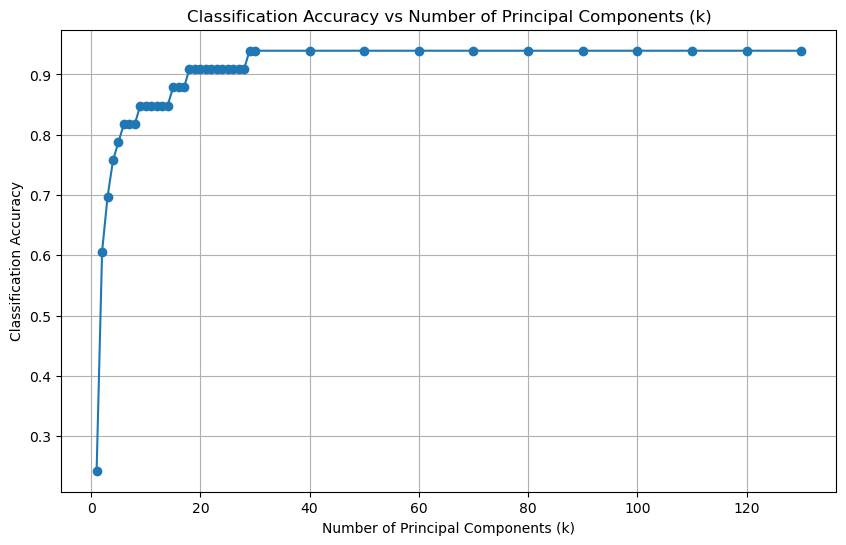

In [15]:
# Visualize the accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(results['k'], results['accuracy'], marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs Number of Principal Components (k)')
plt.grid()

As we can see, as $k$ increases from 0, the classification accuracy increases. However, it remains the same from $k \le 29$. When the value of $k$ is too small, the classification performance is not optimal due to the loss of information. The performance increase become marginal with larger $k$, as each included principal component contributes less to the data variance.
We do not see a decrease of performance accuracy with a large $k$. That's is likely because that our dataset is small and the train size of $n=132$ gives a upper bound for $k$. I hypothesize that $k$ is simply not large enough to cause overfitting over the noise introduced by excessive components and/or run into issue with the curse of dimensionality (failing distance metrics).